# Introduction to Data Science
## Homework 4 

Student Name: Harshit Srivastava

Student Netid: hs3500
***

In this assignment we will be looking at data generated by particle physicists to test whether machine learning can help classify whether certain particle decay experiments identify the presence of a Higgs Boson. One does not need to know anything about particle physics to do well here, but if you are curious, full feature and data descriptions can be found here:

- https://www.kaggle.com/c/higgs-boson/data
- http://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf

The goal of this assignment is to learn to use cross-validation for model selection as well as bootstrapping for error estimation. We’ll also use learning curve analysis to understand how well different algorithms make use of limited data. For more documentation on cross-validation with Python, you can consult the following:

- http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation


### Part 1: Data preparation (5 points)
Create a data preparation and cleaning function that does the following:
- Has a single input that is a file name string
- Reads data (the data is comma separated, has a row header and the first column `EventID` is the index) into a pandas `dataframe`
- Cleans the data
  - Convert the feature `Label` to numeric (choose the minority class to be equal to 1)
    - Create a feature `Y` with numeric label
    - Drop the feature `Label`
  - If a feature has missing values (i.e., `-999`): 
    - Create a dummy variable for the missing value
      - Call the variable `orig_var_name` + `_mv` where `orig_var_name` is the name of the actual var with a missing value
      - Give this new variable a 1 if the original variable is missing
    - Replace the missing value with the average of the feature (make sure to compute the mean on records where the value isn't missing). You may find pandas' `.replace()` function useful.
- After the above is done, rescales the data so that each feature has zero mean and unit variance (hint: look up sklearn.preprocessing)
- Returns the cleaned and rescaled dataset

Hint: as a guide, this function can easily be done in less than 15 lines.

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

In [66]:
def cleanBosonData(infile_name):
    
    ##### Reads Data into Pandas DataFrame #####
    df = pd.read_csv(infile_name)

    ##### Convert feature 'label' to numeric and store it in 'Y' #####
    # Storing the maximum occuring
    a=df['Label'].value_counts().idxmax()
    #creating the new column 'Y'
    df['Y']= (df['Label']!=a).astype(int)
    df=df.drop(['Label'], axis=1)
    
    ##### Creating dummy variable for missing values
    df['DER_mass_MMC_mv']=df['DER_mass_MMC'].replace(-999,1)
    df['DER_deltaeta_jet_jet_mv']=df['DER_deltaeta_jet_jet'].replace(-999,1)
    df['DER_mass_jet_jet_mv']=df['DER_mass_jet_jet'].replace(-999,1)
    df['DER_prodeta_jet_jet_mv']=df['DER_prodeta_jet_jet'].replace(-999,1)
    
    ##### Setting the Index to 'EventId' column
    df.set_index('EventId', inplace=True)
    
    ##### Replacing -999 with NaN
    for col in df:
        df[col] = df[col].replace(-999, np.nan)
    
    ##### Replacing NaN values with the mean of that feature
    df=df.fillna(df.mean())
    
    ##### Re-scaling all the values using StandardScaler() from sklearn.preprocessing
    column=['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_mass_MMC_mv', 'DER_deltaeta_jet_jet_mv', 'DER_mass_jet_jet_mv', 'DER_prodeta_jet_jet_mv']
    for i in column:
        df[i]=scale(df[i])
    column_orig=['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'Y', 'DER_mass_MMC_mv', 'DER_deltaeta_jet_jet_mv', 'DER_mass_jet_jet_mv', 'DER_prodeta_jet_jet_mv']
    data_clean=pd.DataFrame(df, columns=column_orig)
    
    return data_clean

### Part 2: Basic evaluations (5 points)
In this part you will build an out-of-the box logistic regression (LR) model and support vector machine (SVM). You will then plot ROC for the LR and SVM model.

1\. Clean the two data files included in this assignment (`data/boson_training_cut_2000.csv` and `data/boson_testing_cut.csv`) and use them as training and testing data sets.

In [67]:
data_train = cleanBosonData("/Users/harshitsrivastava/Desktop/Data/boson_training_cut_2000.csv")
data_test = cleanBosonData("/Users/harshitsrivastava/Desktop/Data/boson_testing_cut.csv")
data_train.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,Y,DER_mass_MMC_mv,DER_deltaeta_jet_jet_mv,DER_mass_jet_jet_mv,DER_prodeta_jet_jet_mv
EventId,,,,,,,,,,,,,,
100000,3.983624e-01,0.092601,0.491173,-0.444021,-1.650125e+00,-1.135322e+00,1.873193,0.888048,1.120050,1,0.566050,-0.442435,0.089138,1.095553
100001,8.633960e-01,0.608117,0.639363,-0.120744,-4.978417e-16,2.786711e-16,0.000000,1.421917,-0.806390,0,0.920062,-0.359701,-0.387981,0.247408
100002,-3.235580e-15,3.421843,1.261884,-0.321306,-4.978417e-16,2.786711e-16,0.000000,0.997693,-0.455521,0,-1.600056,-0.359701,-0.387981,0.247408
100003,5.108589e-01,0.989159,0.028516,-0.885926,-4.978417e-16,2.786711e-16,0.000000,1.209152,-0.886831,0,0.651689,-0.359701,-0.387981,0.247408
100004,1.172363e+00,-0.953916,1.504447,-0.629578,-4.978417e-16,2.786711e-16,0.000000,1.967534,-0.113790,0,1.155265,-0.359701,-0.387981,0.247408


2\. On the training set, build the following models:

- A logistic regression using sklearn's `linear_model.LogisticRegression()`. For this model, use `C=1e30`.
- An SVM using sklearn's `svm.svc()`. For this model, specify that `kernel="linear"`.

For each model above, plot the ROC curve of both models on the same plot. Make sure to use the test set for computing and plotting. In the legend, also print out the Area Under the ROC (AUC) for reference.

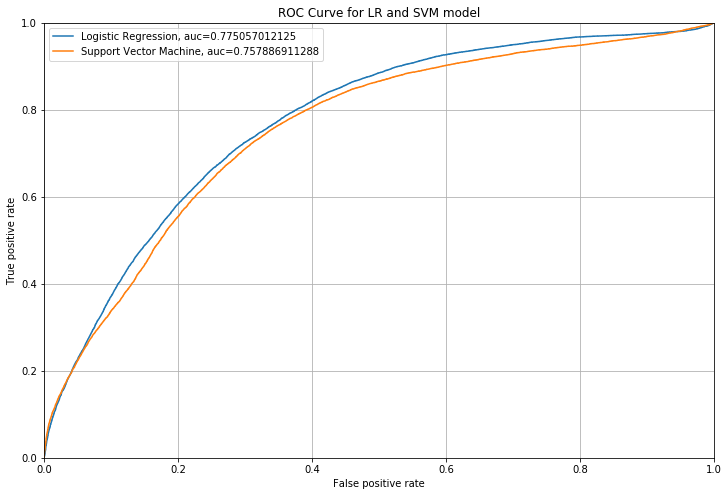

In [68]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score
%matplotlib inline

# Creating Features and Target variables for training and test set
X_data_train= data_train.drop('Y', axis=1).values
Y_data_train= data_train['Y'].values

X_data_test= data_test.drop('Y', axis=1).values
Y_data_test= data_test['Y'].values


# Initializing, fitting and predicting using the Logistic Regression model with C=1e30
LR_model=LogisticRegression(C=1e30)
LR_model.fit(X_data_train, Y_data_train)
LR_pred=LR_model.decision_function(X_data_test)

# Initializing, fitting and predicting using the SVM model with kernel='linear'
SVM_model=SVC(kernel='linear')
SVM_model.fit(X_data_train, Y_data_train)
SVM_pred=SVM_model.decision_function(X_data_test)

# Calculating False positive, True Positive rate and the AUC score of the 2 models
L_fpr, L_tpr, L_thresh=roc_curve(Y_data_test, LR_pred)
S_fpr, S_tpr, S_thresh=roc_curve(Y_data_test, SVM_pred)
L_auc = roc_auc_score(Y_data_test, LR_pred)
S_auc = roc_auc_score(Y_data_test, SVM_pred)

# Plotting the ROC Curve
plt.figure(figsize=[12, 8])
plt.plot(L_fpr, L_tpr, label='Logistic Regression, auc='+str(L_auc))
plt.plot(S_fpr, S_tpr, label='Support Vector Machine, auc='+str(S_auc))

# Adding details to the plot
plt.grid()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="upper left")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Curve for LR and SVM model")
plt.show()


3\. Which of the two models is generally better at ranking the test set? Are there any classification thresholds where the model identified above as "better" would underperform the other in a classification metric (such as TPR)?

<p>
<span style="color:red">
The Logistic Regression model seems to perform better than Support Vector Machines on this dataset. The AUC of the LR model is better than SVM. When the retrieved data nearly equals the total data, the false positive rate (fpr) of LR model seems to increase and touch the maximum value of 1 before the SVM model. So, for larger retrieved data, SVM model should perform better on the "False Positive Rate" metric. For "True Positive Rate" both the models seem to perform equally throughout. 
</span>
</p>

### Part 3: Model selection with cross-validation (10 points)
We think we might be able to improve the performance of the SVM if we perform a grid search on the hyper-parameter $C$.  Because we only have 1000 instances, we will have to use cross-validation to find the optimal $C$.

1\. Write a cross-validation function that does the following:
- Takes as inputs a dataset, a label name, # of splits/folds (`k`), a sequence of values for $C$ (`cs`)
- Performs two loops
  - Outer Loop: `for each f in range(k)`:
    - Splits the data into `data_train` & `data_validate` according to cross-validation logic
  - Inner Loop: `for each c in cs`:
    - Trains an SVM on training split with `C=c, kernel="linear"`
    - Computes AUC_c_k on validation data
    - Stores AUC_c_k in a  dictionary of values
- Returns a dictionary, where each key-value pair is: `c:[auc-c1,auc-c2,..auc-ck]`

In [83]:
from sklearn.cross_validation import KFold
from sklearn.svm import SVC

def xValSVM(dataset, label_name, k, cs):
    aucs=[]                                                      # To store the key (C) and values (AUC_Score)
    Y_dataset = dataset[label_name].values                       # Target Dataset
    X_dataset = dataset.drop(label_name, axis=1).values          # Features dataset
    
    for f in range(2,k+2):
        kf=KFold(len(Y_dataset), n_folds=f)                      # Initializing KFold cross-validation for 'f' folds
        
        for train_indices, test_indices in kf:
            # Sampling the dataset based on the indices returned
            X_train = [X_dataset[ii] for ii in train_indices]
            Y_train = [Y_dataset[ii] for ii in train_indices]
            X_test = [X_dataset[ii] for ii in test_indices]
            Y_test = [Y_dataset[ii] for ii in test_indices]
            
            for c in cs:
                # Initializing, fitting and predicting using the SVM model with C = [10^(-8), ..., 10^1]
                SVM_model=SVC(kernel = 'linear', C=c)
                SVM_model.fit(X_train, Y_train)
                SVM_pred=SVM_model.decision_function(X_test)
                
                # Calculating the AUC score for C and appending them both to a list
                AUC_c_k = roc_auc_score(Y_test, SVM_pred)
                col=[c, AUC_c_k]
                aucs.append(col)
        
    return aucs

2\. Using the function written above, do the following:
- Generate a sequence of 10 $C$ values in the interval `[10^(-8), ..., 10^1]` (i.e., do all powers of 10 from -8 to 1).
2.	Call aucs = xValSVM(train, ‘Y’, 10, cs)
3.	For each c in cs, get mean(AUC) and StdErr(AUC) 
4.	Compute the value for max(meanAUC-StdErr(AUC)) across all values of c.
5.	Generate a plot with the following:
a.	Log10(c) on the x-axis
b.	1 series with mean(AUC) for each c
c.	1 series with mean(AUC)-stderr(AUC) for each c (use ‘k+’ as color pattern)
d.	1 series with mean(AUC)+stderr(AUC) for each c (use ‘k--‘ as color pattern)
e.	a reference line for max(AUC-StdErr(AUC)) (use ‘r’ as color pattern)

Then answer the question: Did the model parameters selected beat the out-of-the-box model for SVM? 

/Users/harshitsrivastava/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/harshitsrivastava/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/harshitsrivastava/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/harshitsrivastava/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:34: Se

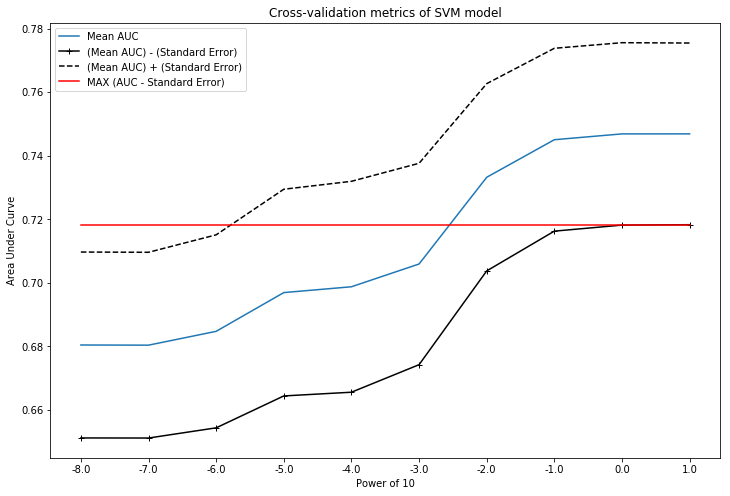

In [84]:
import math

# Generating sequence of 10C values
cs=list()
j=[]
for i in range(-8, 2):
    cs.append(math.pow(10, i))
    
# Calling the function xValSVM with different values of c and f=10
aucs = xValSVM(data_train, 'Y', 10, cs)
aucs=pd.DataFrame(aucs, columns=['C', 'AUC_Score'])
C = aucs['C']
AUC_S = aucs['AUC_Score']

# Accumulating all AUC scores for each value of C
for c in cs:
    m=[]                                              # Creating a list to store all AUC scores (for each C separately)
    for i in range (len(AUC_S)):
        if c == C[i]:                                 # Collecting all AUC scores for the specified value of C
            m.append(AUC_S[i])
    frame=[c, m]
    j.append(frame)

# Converting the list to a DataFrame and adding empty columns to store values of mean, stderr etc. 
j=pd.DataFrame(j)
for k in range (2, 7):
    j[k] = np.nan

for i in range (0, 10):
    dum_v1=np.array(j[1][i])                          # Converting AUC scores list to numpy array
    j[2][i]=dum_v1.mean()                             # Storing mean AUC score in 3rd column
    j[3][i]=np.std(dum_v1)                            # Storing Standard Error in 4th column
    j[4][i] = j[2][i] - j[3][i]                       # Storing (mean AUC score - Standard Error) in 5th column
    j[5][i] = j[2][i] + j[3][i]                       # Storing (mean AUC score + Standard Error) in 6th column

for k in range (0, 10):                               
    j[6][k] = j[4].max()                              # Reference line for max (AUC - Standard Error)

plt.figure (figsize=[12,8])
ls=[]                                                 # Creating list to store log 10 C values
for i in cs:
    ls.append(math.log10(i))
    
# Plotting the different metrics 
plt.figure (figsize=[12,8])
plt.xticks(range(len(ls)), ls)
plt.plot(j[2], label="Mean AUC")
plt.plot(j[4], 'k+-', label="(Mean AUC) - (Standard Error)")
plt.plot(j[5], 'k--', label="(Mean AUC) + (Standard Error)")
plt.plot(j[6], color='r', label="MAX (AUC - Standard Error)")
plt.legend()
plt.xlabel("Power of 10")
plt.ylabel("Area Under Curve")
plt.title("Cross-validation metrics of SVM model")

<p>
<span style="color:red">
By tweeking the model parameters and training the model on different training sets, the AUC score reaches close to 0.76 which is slightly better than the out of the box SVM model used in the previous question. However, there were some values specific to a no. of folds and a C-value that had AUC score close to 0.80 but on taking the mean of all the values for each C, those values were subdued. There was an improvement in the AUC score on using the value of C as 100 and a significant improvement on changing the kernel type from 'linear' to 'rbf' but these results were not plotted as they were not a part of the question. 
</span>
</p>

### Part 4: Learning with Bootstrapping 
In this HW we are trying to find the best linear model to predict if a record represents the Higgs Boson. One of the drivers of the performance of a model is the sample size of the training set.  As a data scientist, sometimes you have to decide if you have enough data or if you should invest in more.  We can use learning curve analysis to determine if we have reached a performance plateau. This will inform us on whether or not we should invest in more data (in this case it would be by running more experiments).

Given a training set of size $N$, we test the performance of a model trained on a subsample of size $N_i$, where $N_i<=N$.  We can plot how performance grows as we move $N_i$ from $0$ to $N$.  

Because of the inherent randomness of subsamples of size $N_i$, we should expect that any single sample of size $N_i$ might not be representative of an algorithm’s performance at a given training set size. To quantify this variance and get a better generalization, we will also use bootstrap analysis. In bootstrap analysis, we pull multiple samples of size $N_i$, build a model, evaluate on a test set, and then take an average and standard error of the results.




1\. Create a bootstrap function that can do the following:

def modBootstrapper(train, test, nruns, sampsize, lr, c):

-	Takes as input:
    -	A master training file (train)
    -	A master testing file (test)
    -	Number of bootstrap iterations (nruns) 
    -	Size of a bootstrap sample (sampsize)
    -	An indicator variable to specific LR or SVM (lr=1)
    -	A c option (only applicable to SVM)

-	Runs a loop with (nruns) iterations, and within each loop:
    -	Sample (sampsize) instances from train, with replacement
    -	Fit either an SVM or LR (depending on options specified). For SVM, use the value of C identified using the 1 standard error method from part 3.    
    -	Computes AUC on test data using predictions from model in above step
    -	Stores the AUC in a list

-	Returns the mean(AUC) and Standard Error(mean(AUC)) across all bootstrap samples


In [85]:

def modBootstrapper(train, test, nruns, sampsize, lr, c):
    AUC = []
    aucs = []
    for s in sampsize:
        
        for i in range(nruns):
            
            # Using df.sample() function of pandas to generate random samples with replacement
            bs_sample = train.sample(s, replace=True)            
            Y_train = bs_sample['Y'].values                 # Target variable for training set
            X_train = bs_sample.drop('Y', axis=1).values    # Features variable for training set
            Y_test = test['Y'].values                       # Target variable for training set
            X_test = test.drop('Y', axis=1).values          # Features variable for testing set
            
            if lr == 1:
                # Calculating AUC scores for Logistic Regression model using the given parameters
                LR_model=LogisticRegression(C=c)
                LR_model.fit(X_train, Y_train)
                LR_pred=LR_model.decision_function(X_test)
                AUC_sampsize = roc_auc_score(Y_test, LR_pred)
                AUC.append(AUC_sampsize)
            else:
                # Calculating AUC scores for SVM model using the given parameters
                SVM_model=SVC(kernel='linear', C=c)
                SVM_model.fit(X_train, Y_train)
                SVM_pred=SVM_model.decision_function(X_test)
                AUC_sampsize = roc_auc_score(Y_test, SVM_pred)
                AUC.append(AUC_sampsize)
        
        # Returning sample size, mean and stderr of the model selected
        aucs_mean = sum(AUC)/len(AUC)   
        aucs_std = np.std(AUC)
        frame = [s, aucs_mean, aucs_std]                          
        aucs.append(frame)
        
    return aucs

2\. For both LR and SVM, run 20 bootstrap samples for each samplesize in the following list: samplesizes = [50, 100, 200, 500, 1000, 1500, 2000]. (Note, this might take 10-15 mins … feel free to go grab a drink or watch Youtube while this runs).

Generate a plot with the following:
-	Log2(samplesize) on the x-axis
-	2 sets of results lines, one for LR and one for SVM, the set should include
    -	1 series with mean(AUC) for each sampsize (use the color options ‘g’ for svm, ‘r’ for lr)
    -	1 series with mean(AUC)-stderr(AUC) for each c (use ‘+’ as color pattern, ‘g’,’r’ for SVM, LR respectively)
    -	1 series with mean(AUC)+stderr(AUC) for each c (use ‘--‘ as color pattern ‘g’,’r’ for SVM, LR respectively)


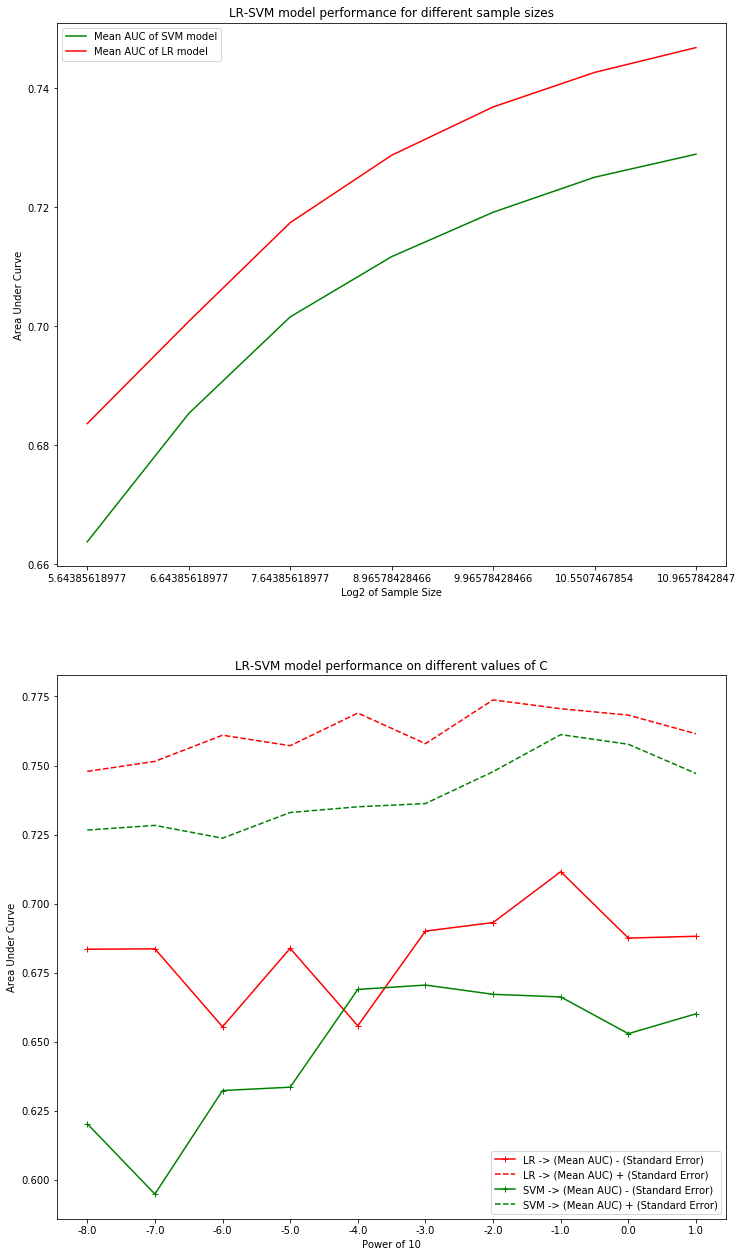

In [87]:
# Generating list of Sample sizes
sampsize = [50, 100, 200, 500, 1000, 1500, 2000]

# Calling the Logistic Regression model for C = 10
LR_bs = modBootstrapper(data_train, data_test, 20, sampsize, 1, 10)
LR_bs = pd.DataFrame(LR_bs)

## Calling the SVM model for C = 10
SVM_bs = modBootstrapper(data_train, data_test, 20, sampsize, 0, 10)
SVM_bs = pd.DataFrame(SVM_bs)

# Creating list to store log2(sample_size) values
lt=[]                                                 
for i in sampsize:
    lt.append(math.log(i, 2))

# Plotting the mean AUC score of the 2 models for C = 10
plt.figure(figsize=(12,22))
plt.subplot(2, 1, 1)
plt.xticks(range(len(lt)), lt)
plt.plot(SVM_bs[1], label="Mean AUC of SVM model", color='g')
plt.plot(LR_bs[1], label="Mean AUC of LR model", color='r')
plt.legend()
plt.xlabel("Log2 of Sample Size")
plt.ylabel("Area Under Curve")
plt.title("LR-SVM model performance for different sample sizes")

LR_bs_c = []
SVM_bs_c = []

# Calculating mean, std for the 2 models
for c in cs:
    ls_lr = []
    ls_svm = []
    # Calling Logistic Regression model for different values of C
    ls_lr = modBootstrapper(data_train, data_test, 20, sampsize, 1, c)
    ls_lr = pd.DataFrame(ls_lr)
    # Mean of the AUC scores and Standard Error
    mn1=ls_lr[1].mean()
    sd1=ls_lr[2].mean()
    frame1 = [c, mn1, sd1]
    LR_bs_c.append(frame1)
    
    # Calling the SVM model for different values of C
    ls_svm = modBootstrapper(data_train, data_test, 20, sampsize, 0, c)
    ls_svm = pd.DataFrame(ls_svm)
    # Mean of the AUC scores and Standard Error
    mn2=ls_svm[1].mean()
    sd2=ls_svm[2].mean()
    frame2 = [c, mn2, sd2]
    SVM_bs_c.append(frame2)

# Converting to DataFrame for ease of use
LR_bs_c = pd.DataFrame(LR_bs_c)
SVM_bs_c = pd.DataFrame(SVM_bs_c)

# Creating new columns to fill (mean AUC + Standard Error) and (mean AUC - Standard Error)
LR_bs_c[3] = np.nan
LR_bs_c[4] = np.nan
SVM_bs_c[3] = np.nan
SVM_bs_c[4] = np.nan

# Calculating the metrics for Logistic Regression model
for i in range (len(LR_bs_c[1])):
    LR_bs_c[3][i] = LR_bs_c[1][i] - LR_bs_c[2][i]
    LR_bs_c[4][i] = LR_bs_c[1][i] + LR_bs_c[2][i]
    
# Calculating the metrics for SVM model
for i in range (len(SVM_bs_c[1])):
    SVM_bs_c[3][i] = SVM_bs_c[1][i] - SVM_bs_c[2][i]
    SVM_bs_c[4][i] = SVM_bs_c[1][i] + SVM_bs_c[2][i]
    
# Plotting the metrics for different values of C
plt.subplot(2, 1, 2)
plt.xticks(range(len(ls)), ls)
# Plotting for Logistic Regression model
plt.plot(LR_bs_c[3], 'r+-', label="LR -> (Mean AUC) - (Standard Error)")
plt.plot(LR_bs_c[4], 'r--', label="LR -> (Mean AUC) + (Standard Error)")
# Plotting for SVM model
plt.plot(SVM_bs_c[3], 'g+-', label="SVM -> (Mean AUC) - (Standard Error)")
plt.plot(SVM_bs_c[4], 'g--', label="SVM -> (Mean AUC) + (Standard Error)")
plt.legend()
plt.xlabel("Power of 10")
plt.ylabel("Area Under Curve")
plt.title("LR-SVM model performance on different values of C")

3\. Which of the two algorithms are more suitable for smaller sample sizes, given the set of features? If it costs twice the investment to run enough experiments to double the data, do you think it is a worthy investment?


<p>
<span style="color:red">
Logistic Regression algorithm performs better for smaller sample size and that performance seems to be better than SVM even as the sample size is increased.
If it takes twice the cost to double the data, then bootstrapping method should be chosen as different samples can be taken out of the same data set but this can only be true in cases where the present data set is a true representation of the complete range of values. If on running the experiments again, we are expected to get different range of values, then the experiments should be run again as the present data set will not be the true representation of all set of values. 
</span>
</p>

4\. Is there a reason why cross-validation might be biased? If so, in what direction is it biased?



<p>
<span style="color:red">
From the results, it doesn't look like cross-validation is biased. The scores obtained are almost identical for the 2 methods and show similar trends throughout. 
</span>
</p>